# Running the nonadiabatic molecular dynamics (NA-MD)

In this tutorial, we conduct NBRA NA-MD calculations using the Libra code. This version implements the generic dynamical approach that is common to model-based NA-MD simulations and the one based on reading files. In this particular case, we setup the interface to pre-computed energy and time-overlap files (as could be produced by any codes) and use it in the generic dynamical workflow.

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Read the files in a selected basis](#2)
3. [Computing the average energy gaps and decoherence times](#gap_deco)
4. [Define the interface](#def_interface)
5. [Define parameters and run the calculations](#5) 
6. [Run NAMD simulations](#run_namd)\
   6.1. [FSSH with no decoherence correction method](#FSSH)\
   6.2. [mSDM method](#mSDM)\
   6.3. [IDA method](#IDA)\
   6.4. [DISH method](#DISH)
7. [Plot the results using `plot_dynamics`](#plot_res)

### A. Learning objectives

* To set up and run file-based NBRA NA-MD calculations with different methods

### B. Use cases

* [Run NAMD simulations](#run_namd)
* [Plot the results using `plot_dynamics`](#plot_res)

### C. Functions

- `libra_py`
  - `dynamics`
    - `tsh`
      - `compute`
        - [`generic_recipe`](#run_namd)
      - `plot`
        - [`plot_dynamics`](#plot_res)
  - `data_conv`
    - [`nparray2CMATRIX`](#gap_deco)
  - `units`
    - [`au2ev`](#gap_deco)
    - [`au2fs`](#gap_deco)
    

## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

First, let's import all necessary libraries and define parameters such as colors

In [29]:
import os
import matplotlib.pyplot as plt   # plots
import numpy as np
import scipy.sparse as sp
import h5py
import warnings

from liblibra_core import *
import util.libutil as comn
from libra_py import units, data_conv, dynamics_plotting
import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot
import libra_py.data_savers as data_savers
import libra_py.workflows.nbra.decoherence_times as decoherence_times


#from matplotlib.mlab import griddata
#%matplotlib inline 
warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]


## 2. Read the files in a selected basis<a name="2"></a>
[Back to TOC](#toc)

Here, we will be reading the files required for NBRA-NAMD simulations. In this example, we select the MB basis where the overlaps and energies are computed in the `res-mb-sd-DFT` folder. This folder is `../8_step3/1_DFT/res-mb-sd-DFT`. The parameters in the cell below are:

`istep`: The initial step 

`fstep`: The final step  

`NSTEPS`: Number of steps which is `fstep-istep`

Note that all the files from `istep` to `fstep-1` should exist. 

In [30]:
path_to_save_sd_Hvibs = '../8_step3/1_DFT/res-mb-sd-DFT'
istep = 1200
fstep = 1400
NSTEPS = fstep - istep
#================== Read energies =====================
E = []
for step in range(istep,fstep):
    energy_filename = F"{path_to_save_sd_Hvibs}/Hvib_ci_{step}_re.npz"
    energy_mat = sp.load_npz(energy_filename)
    # For data conversion we need to turn np.ndarray to np.array so that 
    # we can use data_conv.nparray2CMATRIX
    E.append( np.array( np.diag( energy_mat.todense() ) ) )
E = np.array(E)
NSTATES = E[0].shape[0]
#================== Read time-overlap =====================
St = []
for step in range(istep,fstep):        
    St_filename = F"{path_to_save_sd_Hvibs}/St_ci_{step}_re.npz"
    St_mat = sp.load_npz(St_filename)
    St.append( np.array( St_mat.todense() ) )
St = np.array(St)
#================ Compute NACs and vibronic Hamiltonians along the trajectory ============    
NAC = []
Hvib = [] 
for c, step in enumerate(range(istep,fstep)):
    nac_filename = F"{path_to_save_sd_Hvibs}/Hvib_ci_{step}_im.npz"
    nac_mat = sp.load_npz(nac_filename)
    NAC.append( np.array( nac_mat.todense() ) )
    Hvib.append( np.diag(E[c, :])*(1.0+1j*0.0)  - (0.0+1j)*nac_mat[:, :] )

NAC = np.array(NAC)
Hvib = np.array(Hvib)

print('Number of steps:', NSTEPS)
print('Number of states:', NSTATES)

Number of steps: 200
Number of states: 11


In [33]:
print(NAC.shape)
print(Hvib.shape)
print(St.shape)

(200, 11, 11)
(200, 11, 11)
(200, 11, 11)


## 3. Computing the average energy gaps and decoherence times<a name="gap_deco"></a>
[Back to TOC](#toc)

Below, we compute the average energy gaps and decoherence times between all states. The average gaps matrix, `gaps`, and average decoherence times and rates, `avg_deco` and `rates`, are required for NAMD with decoherence methods.

In [31]:
# ================= Computing the energy gaps and decoherence times
HAM_RE = []
for step in range(E.shape[0]):
    HAM_RE.append( data_conv.nparray2CMATRIX( np.diag(E[step, : ]) ) )
# Average decoherence times and rates
tau, rates = decoherence_times.decoherence_times_ave([HAM_RE], [0], NSTEPS, 0)
# Computes the energy gaps between all states for all steps
dE = decoherence_times.energy_gaps_ave([HAM_RE], [0], NSTEPS)
# Decoherence times in fs
avg_deco = data_conv.MATRIX2nparray(tau) * units.au2fs
# Zero all the diagonal elements of the decoherence matrix
np.fill_diagonal(avg_deco, 0)
# Saving the average decoherence times
np.savetxt('avg_deco.txt',avg_deco.real)
# Computing the average energy gaps
gaps = MATRIX(NSTATES, NSTATES)
for step in range(NSTEPS):
    gaps += dE[step]
gaps /= NSTEPS

## 4. Define the interface <a name="def_interface"></a>
[Back to TOC](#toc)

The interface function should be defined as explained in other tutorials. It should return objects with the specifically-named data members. This is what we defined here:
<a name="nparray2CMATRIX-1"></a><a name="use_case-3"></a>

In [5]:
class tmp:
    pass

def compute_model(q, params, full_id):
    timestep = params["timestep"]
    nst = params["nstates"]
    obj = tmp()

    obj.ham_adi = data_conv.nparray2CMATRIX( np.diag(E[timestep, : ]) )
    obj.nac_adi = data_conv.nparray2CMATRIX( NAC[timestep, :, :] )
    obj.hvib_adi = data_conv.nparray2CMATRIX( Hvib[timestep, :, :] )
    obj.basis_transform = CMATRIX(nst,nst); obj.basis_transform.identity()  #basis_transform
    obj.time_overlap_adi = data_conv.nparray2CMATRIX( St[timestep, :, :] )
    
    return obj


## 5. Define parameters and run the calculations <a name="5"></a>
[Back to TOC](#toc)

Make sure you define all of these 4 parameters of the `model_params` dictionary. Here, we first initialize the parameter `timestep` to `0`. This parameter will be updated to `icond` which is representative of the initial geomtery. 

In [6]:
#================== Model parameters ====================
model_params = { "timestep":0, "icond":10,  "model0":0, "nstates":NSTATES }

Dynamics control parameters are as follows:

`nfiles`: The total number of files that was read.

`nsteps`: The total number of steps for dynamics. Note that this number can be larger than the number of files `nfiles` read. For `nsteps` more than `nfiles`, Libra will repeat the Hamiltonian matrices and do the dynamics.

`ntraj`: The number of surface hopping trajectories.

`dt`: The time step in atomic units.

`decoherence_rates`: The matrix of dephasing rates with a unit of a.u. of time$^{-1}$.

`ave_gaps`: A matrix that contains the averaged moduli of the energy gaps

$$E_{ij}= |E_i - E_j|$$

It is needed when `dephasing_informed` option is used, like DISH method.

`progress_frequency`: At what intervals print out some "progress" messages. For instance, if you have `nsteps = 100` and `progress_frequency = 0.1`, the code will notify you every 10 steps.

`which_adi_states`: Indices of the adiabatic states to plot.

`which_dia_states`: Indices of the diabatic states to plot.

`mem_output_level`: Controls what info to save into HDF5 files (all at the end) Same meaning and output as with `hdf5_output_level`, except all the variables are first stored in memory (while the calcs are running) and then they are written into the HDF5 file at the end of the calculations. This is a much faster version of hdf5 saver.

`properties_to_save`: Describes what properties to save to the HDF5 files. Note that if some properties are not listed in this variable, then they are not saved, even if `mem_output_level` suggests they may be saved. You need to BOTH set the appropriate `mem_output_level` AND `properties_to_save`:

```
default:  [ "timestep", "time", "Ekin_ave", "Epot_ave", "Etot_ave", 
         "dEkin_ave", "dEpot_ave", "dEtot_ave", "states", "SH_pop", "SH_pop_raw",
         "D_adi", "D_adi_raw", "D_dia", "D_dia_raw", "q", "p", "Cadi", "Cdia", 
         "hvib_adi", "hvib_dia", "St", "basis_transform", "projector"]
```

`prefix`: The name of the folder to be created by this function. All the data files will be created in that folder.

`isNBRA`: A flag for NBRA type of calculations.

Other parameters for NBRA-specific parameters are explained in the comments of the cell below.

In [7]:
#=============== Some automatic variables, related to the settings above ===================

dyn_general = { "nsteps":NSTEPS*2, "ntraj":25, "nstates":NSTATES, "dt":1.0*units.fs2au, "nfiles": NSTEPS,
                "decoherence_rates":rates, "ave_gaps": gaps,
                "progress_frequency":0.1, "which_adi_states":range(NSTATES), "which_dia_states":range(NSTATES),
                "mem_output_level":2,
                "properties_to_save":[ "timestep", "time","se_pop_adi", "sh_pop_adi" ],
                "prefix":F"NBRA", "isNBRA":0
              }

#=========== Some NBRA-specific parameters - these are the key settings for running file-based NBRA calculations ===========

dyn_general.update({"ham_update_method":2})  # read adiabatic properties from mthe files

dyn_general.update({"ham_transform_method":0})  # don't attempt to compute adiabatic properties from the diabatic ones, not to
                                                # override the read ones 
    
dyn_general.update({"time_overlap_method":0})  # don't attempt to compute those, not to override the read ones

dyn_general.update({"nac_update_method":0})    # don't attempt to recompute NACs, so that we don't override the read values

dyn_general.update({"hvib_update_method":0})   # don't attempt to recompute Hvib, so that we don't override the read values


dyn_general.update( {"force_method":0, "rep_force":1} ) # NBRA = don't compute forces, so rep_force actually doesn't matter


dyn_general.update({"hop_acceptance_algo":32, "momenta_rescaling_algo":0 })  # accept based on Boltzmann, no velocity rescaling

dyn_general.update( {"rep_tdse":1}) # the TDSE integration is conducted in adiabatic rep

dyn_general.update( {"electronic_integrator":2} )  # using the local diabatization approach to integrate TD-SE

[Back to TOC](#toc)

Now, we define the nuclear and electronic parameters. The nuclear parameters do not matter in the NBRA-NAMD. The initial state is defined in the `elec_params` with the `istate` parameter. `rep` shows in which representation the dynamics should be done where `1` is the adiabatic representation and `0` shows the dynamics in diabatic representation.

Other parameters in the `elec_params` are used for density matrix and amplitudes initialization.

In [8]:
#=================== Dynamics =======================
# Nuclear DOF - these parameters don't matter much in the NBRA calculations
nucl_params = {"ndof":1, "init_type":3, "q":[-10.0], "p":[0.0], "mass":[2000.0], "force_constant":[0.01], "verbosity":-1 }

# Amplitudes are sampled
elec_params = {"ndia":NSTATES, "nadi":NSTATES, "verbosity":-1, "init_dm_type":0}


elec_params.update( {"init_type":1,  "rep":1,  "istate":10 } )  # how to initialize: random phase, adiabatic representation, given initial state

## 6. Run NAMD simulation <a name="run_namd"></a>
[Back to TOC](#toc)

Here, we start doing NAMD calculations using different methods, FSSH, mSDM, IDA, and DISH. For each method, we need to change the parameters in `dyn_general`. We run the calculations for initial conditions in `range(0,200,10)`. For running each calculations we update the `prefix` to `F'{method}_NBRA_icond_{icond}'`. We then will be using these folders and date stored in them to plot the dynamics and compute the timescales.

### 6.1. FSSH with no decoherence correction method <a name="FSSH"></a>
[Back to TOC](#toc)

The `dyn_general` parameters for FSSH calculations are as follows:

In [17]:
#============ Surface hopping opntions =================
dyn_general.update({"tsh_method":0 }) # FSSH
dyn_general.update({ "decoherence_algo":-1}) # no (additional) decoherence
dyn_general.update({"decoherence_times_type":-1 }) # No decoherence times, infinite decoherence times
dyn_general.update({"do_ssy":0 }) # do no use Shenvi-Subotnik-Yang phase correction
dyn_general.update({"dephasing_informed":0}) # no dephasing-informed correction

In [19]:
rnd = Random()

for icond in range(0,200,10):
    print('Running the calculations for icond:', icond)
    model_params.update({"icond": icond})
    dyn_general.update({"prefix":F"FSSH_NBRA_icond_{icond}"})
    res = tsh_dynamics.generic_recipe(dyn_general, compute_model, model_params, elec_params, nucl_params, rnd)

Running the calculations for icond: 0
e default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 10
ut parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2


 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 20
defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset n

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 40
NG: Parameter txt_output_level is not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the datase

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 60
parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
S

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 80
ut_level is not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Savi

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 100
lt value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset name

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 120
! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named s

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 140
NING: Parameter prefix2 is not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset name

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 160
t parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/dat

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 180
c_substeps is not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
S

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data


### 6.2. mSDM method <a name="mSDM"></a>
[Back to TOC](#toc)

The `dyn_general` parameters for calculations with mSDM decoherence method are as follows:

In [20]:
#============ Surface hopping opntions =================
dyn_general.update({"tsh_method":0 }) # FSSH
dyn_general.update({ "decoherence_algo":0}) # mSDM
dyn_general.update({"decoherence_times_type":0 }) # use the rates read out from the input, need decoherence_rates input
dyn_general.update( {"dephasing_informed":0} ) # no dephasing-informed correction

In [21]:
rnd = Random()

for icond in range(0,200,10):
    print('Running the calculations for icond:', icond)
    model_params.update({"icond": icond})
    dyn_general.update({"prefix":F"mSDM_NBRA_icond_{icond}"})
    res = tsh_dynamics.generic_recipe(dyn_general, compute_model, model_params, elec_params, nucl_params, rnd)

Running the calculations for icond: 0
alue 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 10
rsUse the default value 
In cctor: lvl = 1 der_lvl = 2


 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 20
 the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 40
er constrained_dofs is not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named tim

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 60
se the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the d

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 80
 not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the data

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 100

In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 120
input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 140
r quantum_dofs is not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/da

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 160
e the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the d

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 180
not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the data

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data


### 6.3. IDA method <a name="IDA"></a>
[Back to TOC](#toc)

The `dyn_general` parameters for calculations with IDA decoherence method are as follows:

In [22]:
#============ Surface hopping opntions =================
dyn_general.update({"tsh_method":0 }) # FSSH
dyn_general.update({ "decoherence_algo":1}) # IDA
dyn_general.update({"decoherence_times_type":0 }) # use the rates read out from the input, need decoherence_rates input
dyn_general.update( {"dephasing_informed":0} ) # no dephasing-informed correction

In [23]:
rnd = Random()

for icond in range(0,200,10):
    print('Running the calculations for icond:', icond)
    model_params.update({"icond": icond})
    dyn_general.update({"prefix":F"IDA_NBRA_icond_{icond}"})
    res = tsh_dynamics.generic_recipe(dyn_general, compute_model, model_params, elec_params, nucl_params, rnd)

Running the calculations for icond: 0
RNING: Parameter thermostat_params is not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 10
e default value 
In cctor: lvl = 1 der_lvl = 2


 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 20
ut parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/dat

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 40
er ensemble is not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
S

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 60
se the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the d

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 80
 not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the data

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 100
lue 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 120
the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 140
rameter ETHD3_beta is not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named tim

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 160
tersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 180
ha is not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving th

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data


### 6.4. DISH method <a name="DISH"></a>
[Back to TOC](#toc)

The `dyn_general` parameters for calculations with mSDM decoherence method are as follows:

In [24]:
#============ Surface hopping opntions =================
dyn_general.update({"tsh_method":3 }) # DISH 2
dyn_general.update({ "decoherence_algo":-1}) # DISH 2
dyn_general.update({"decoherence_times_type":0 }) # use the rates read out from the input, need decoherence_rates input
dyn_general.update( {"dephasing_informed":1} ) # dephasing-informed correction

In [25]:
rnd = Random()

for icond in range(0,200,10):
    print('Running the calculations for icond:', icond)
    model_params.update({"icond": icond})
    dyn_general.update({"prefix":F"DISH_NBRA_icond_{icond}"})
    res = tsh_dynamics.generic_recipe(dyn_general, compute_model, model_params, elec_params, nucl_params, rnd)

Running the calculations for icond: 0
lt value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 10
metersUse the default value 
In cctor: lvl = 1 der_lvl = 2


 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 20
! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 40
ameter entanglement_opt is not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 60
ersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving t

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 80
a is not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the 

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 100
arameter schwartz_decoherence_inv_alpha is not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving 

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 120
etersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Savin

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 140
ion is not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving t

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 160
value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named s

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 180
n the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_p

 step= 40
 step= 80
 step= 120
 step= 160
 step= 200
 step= 240
 step= 280
 step= 320
 step= 360
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data


## 7. Plot the results using `plot_dynamics` <a name="plot_res"></a>
[Back to TOC](#toc)

In this cell, we use the function `tsh_dynamics_plot.plot_dynamics` to plot the dynamics for only one initial condition, `icond:0`. The user can change the range of states to be plotted by changing `which_adi_states`. The rest of the parameters are used for plotting and are descriptive.

Plotting results for method FSSH


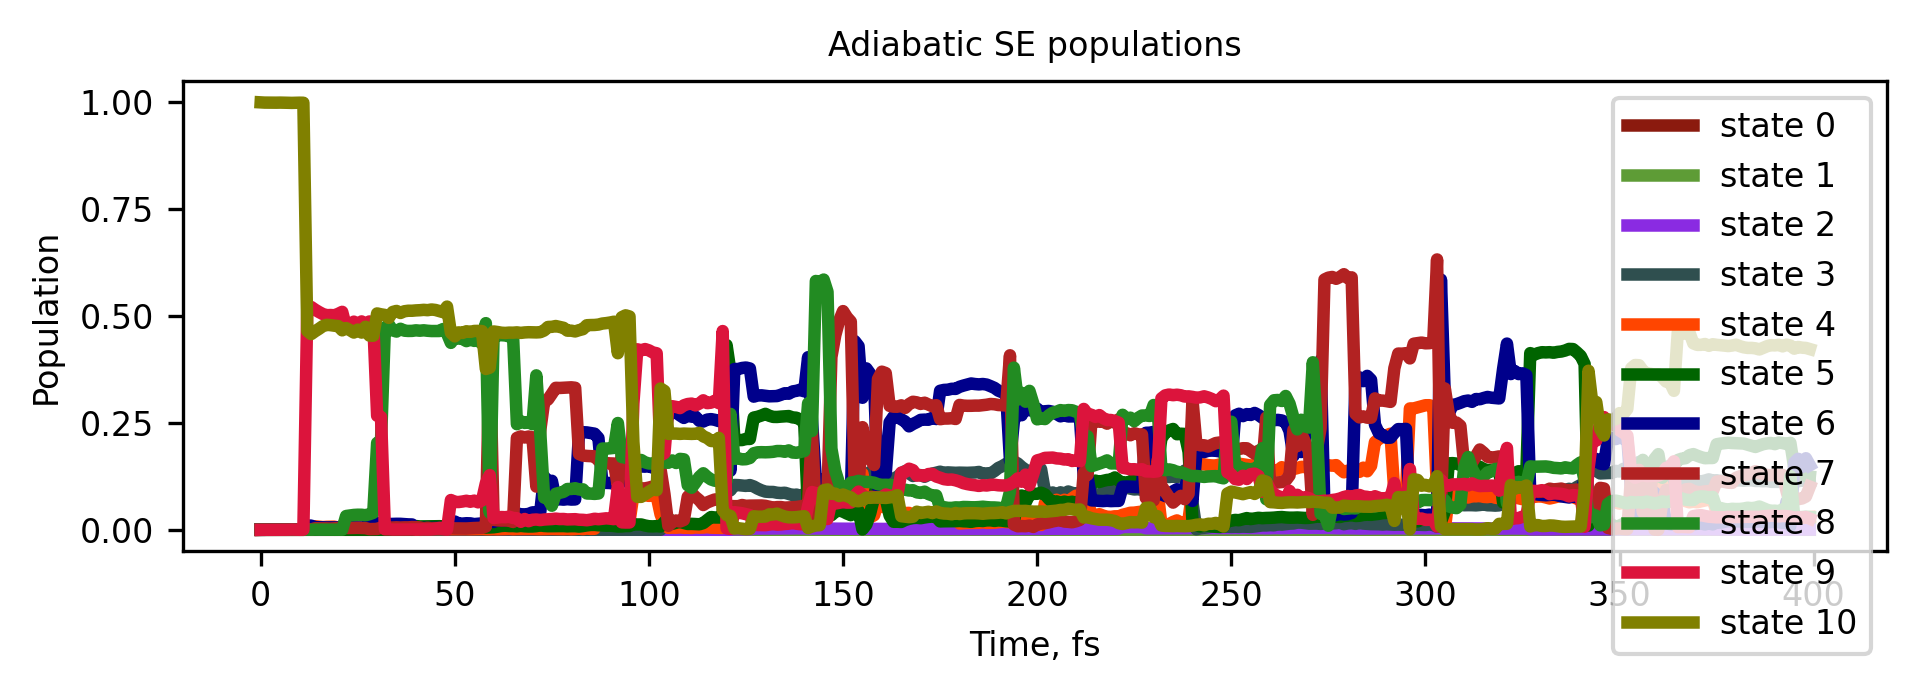

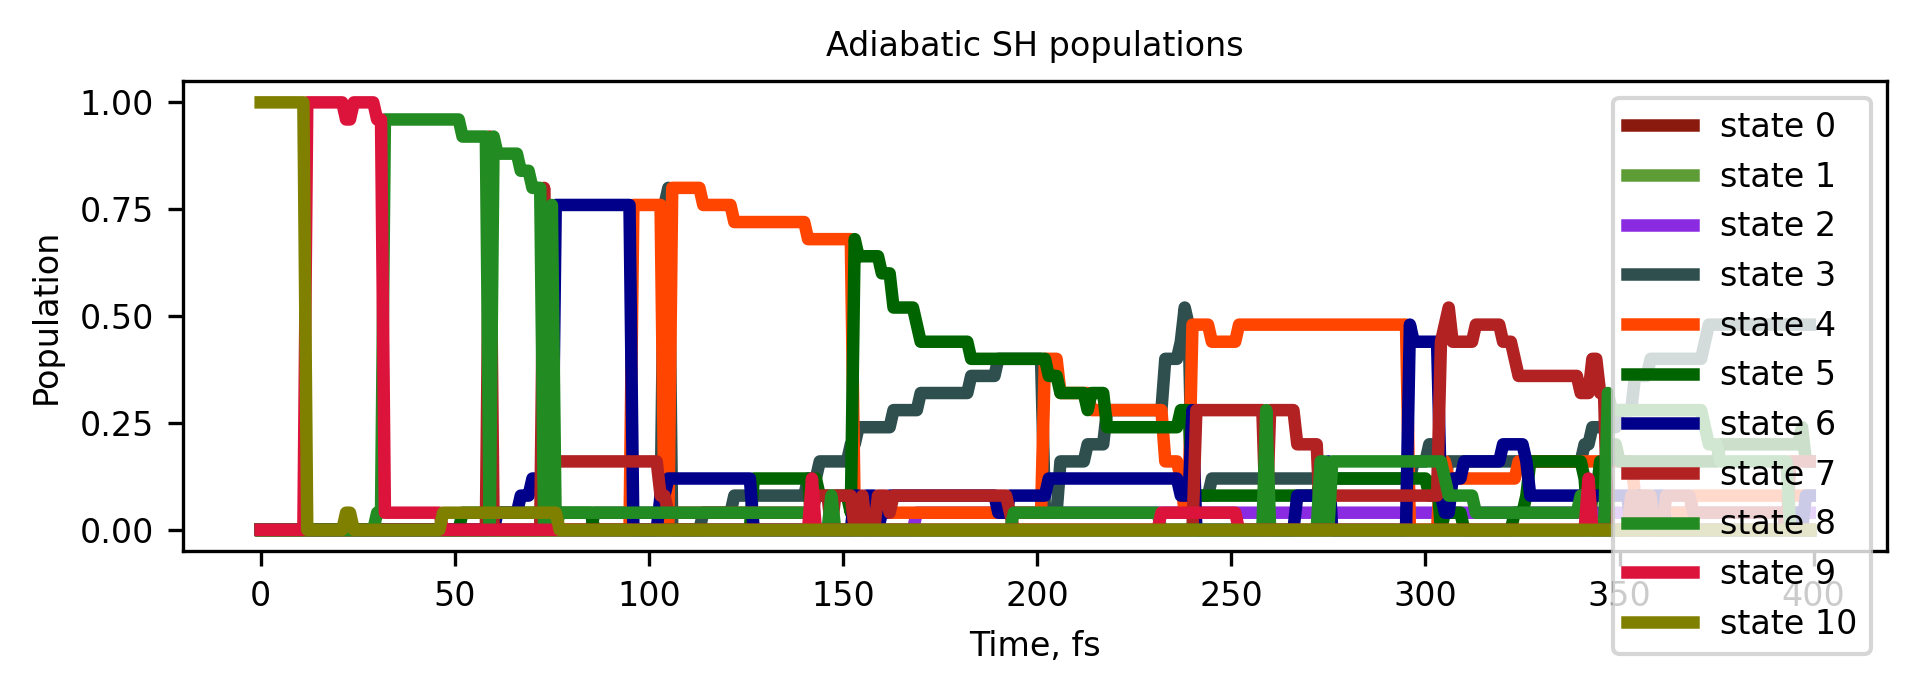

Plotting results for method mSDM
s_index is not defined! in the input parametersUse the default value 

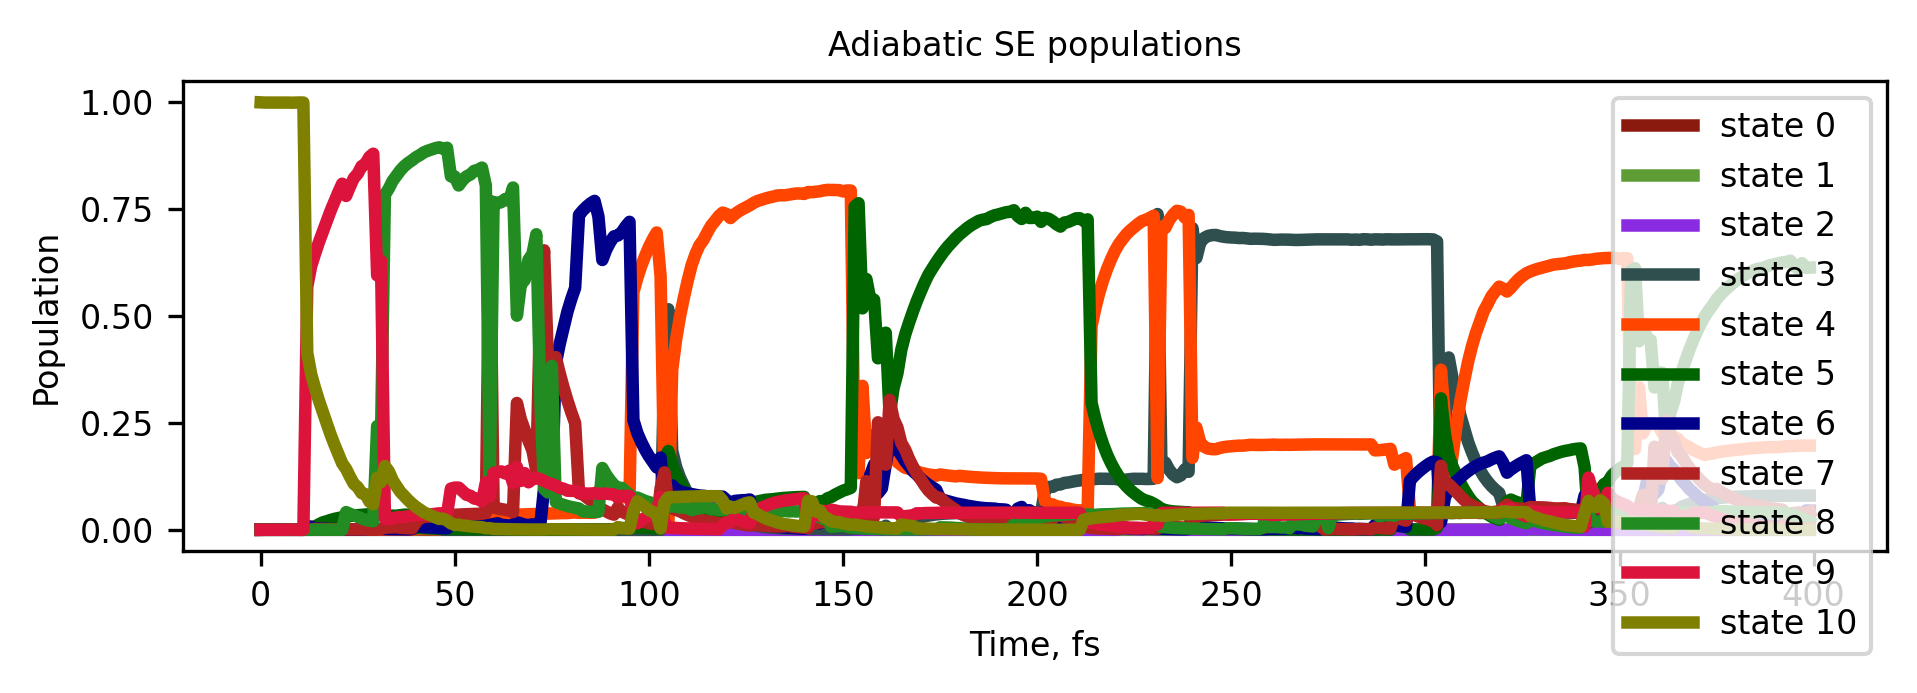

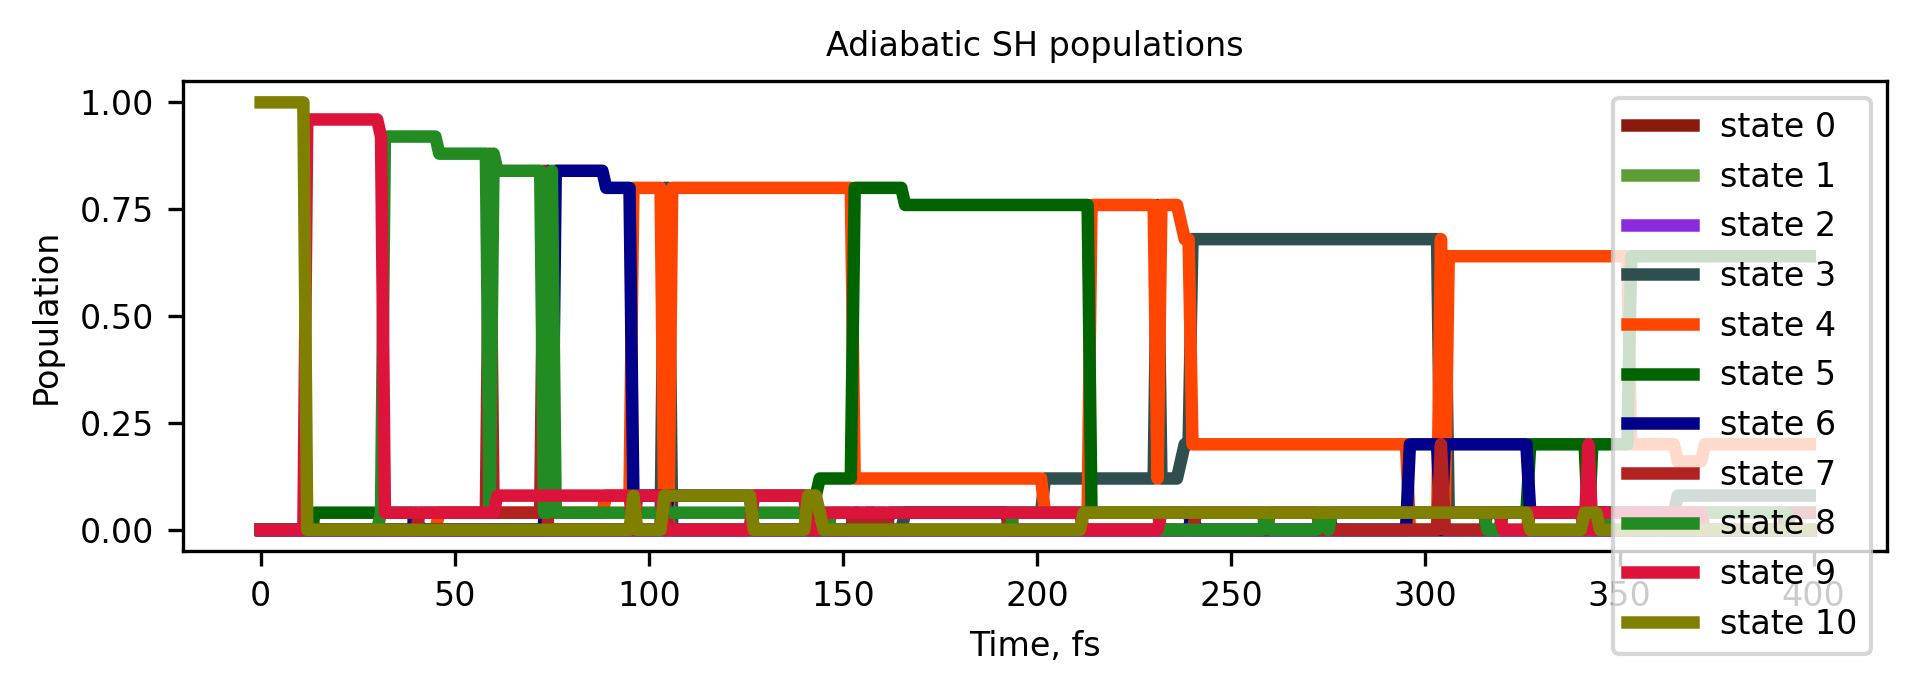

Plotting results for method IDA


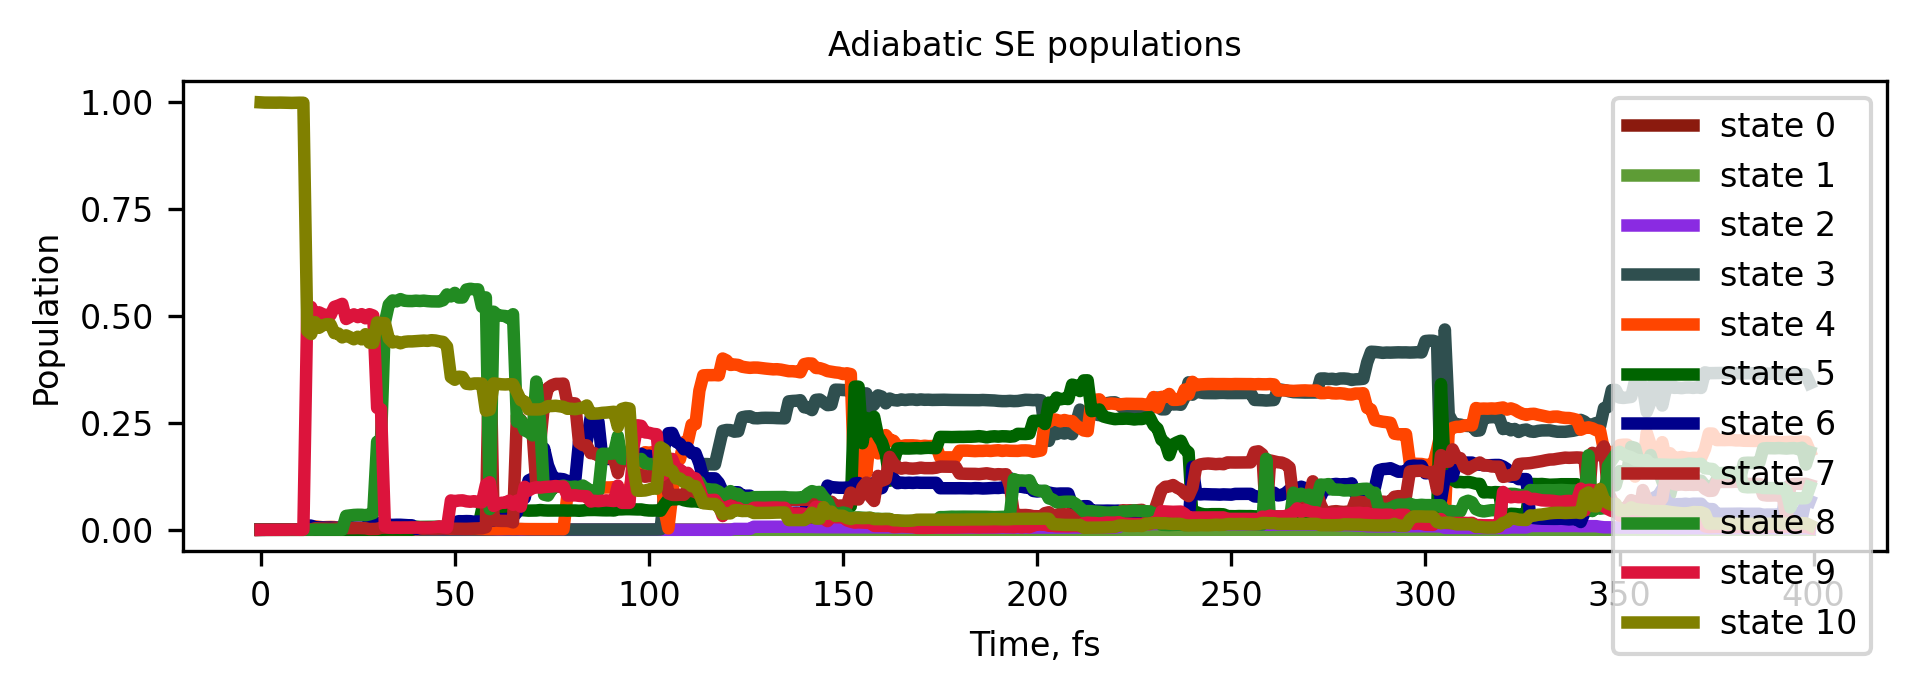

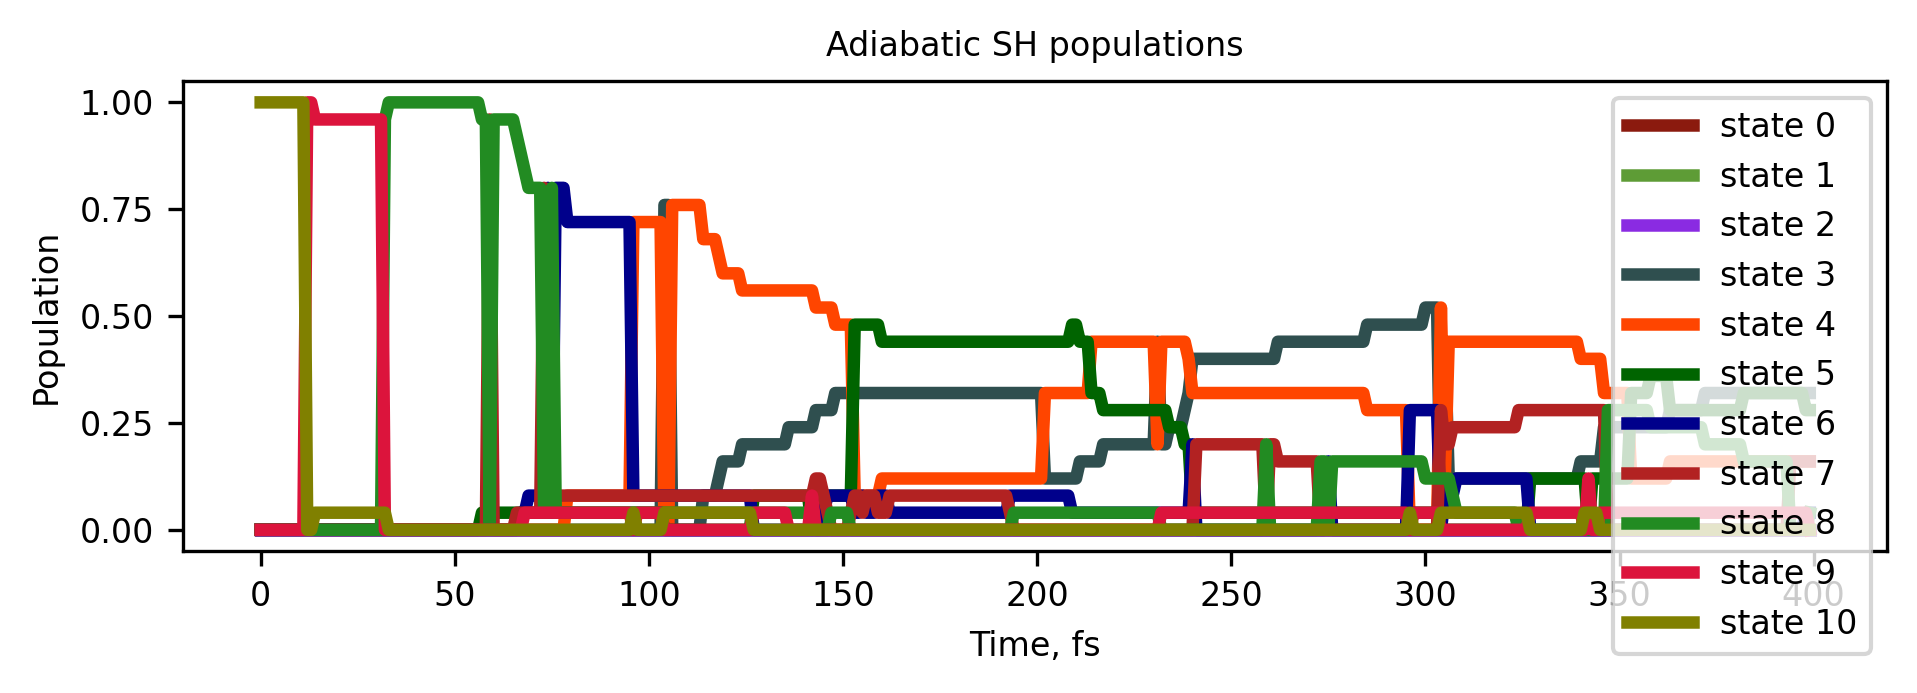

Plotting results for method DISH


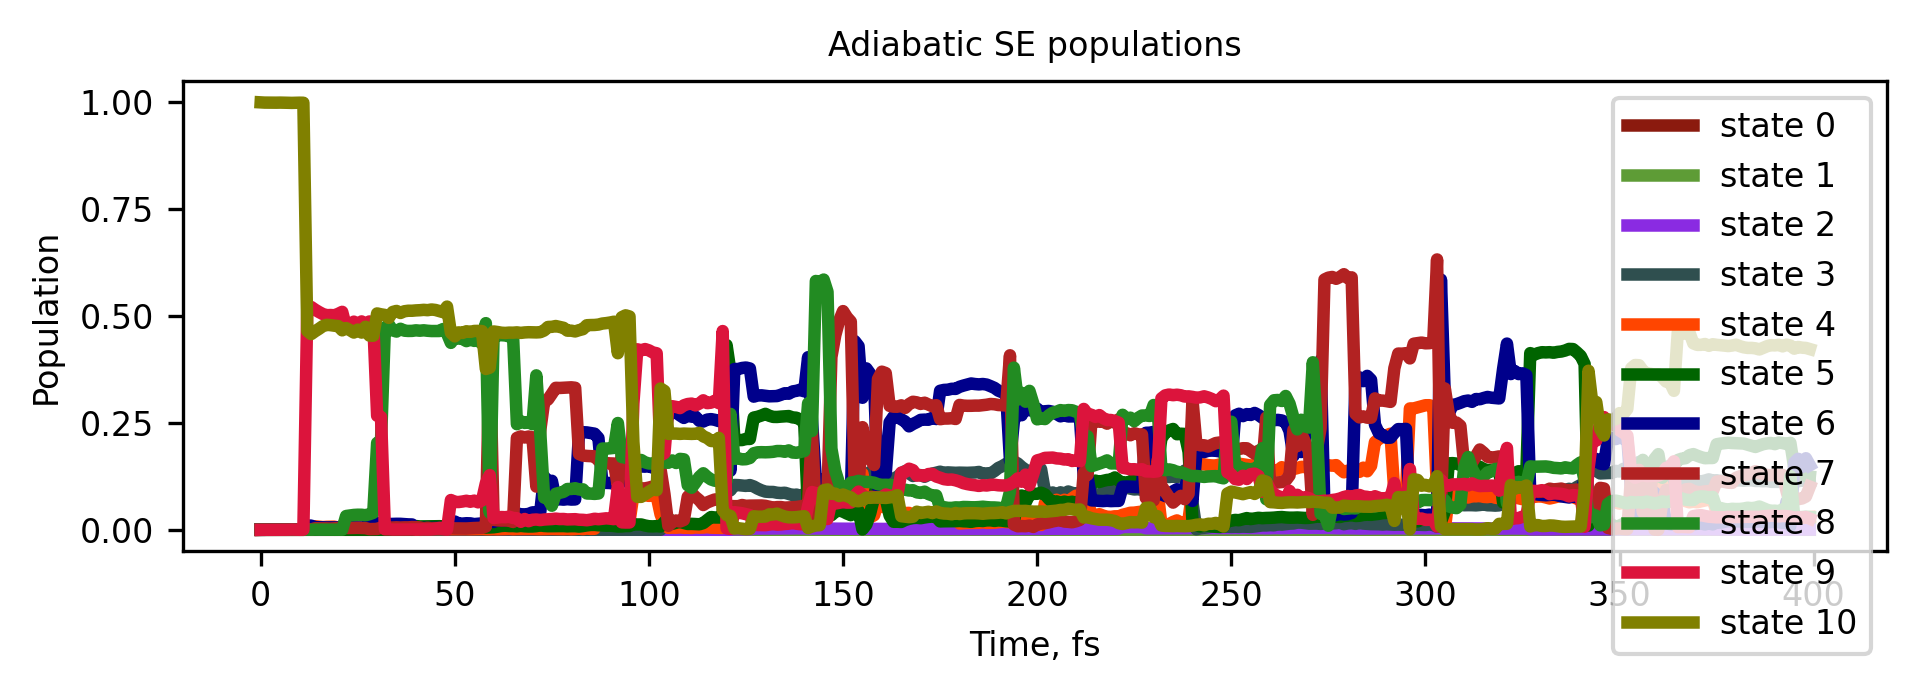

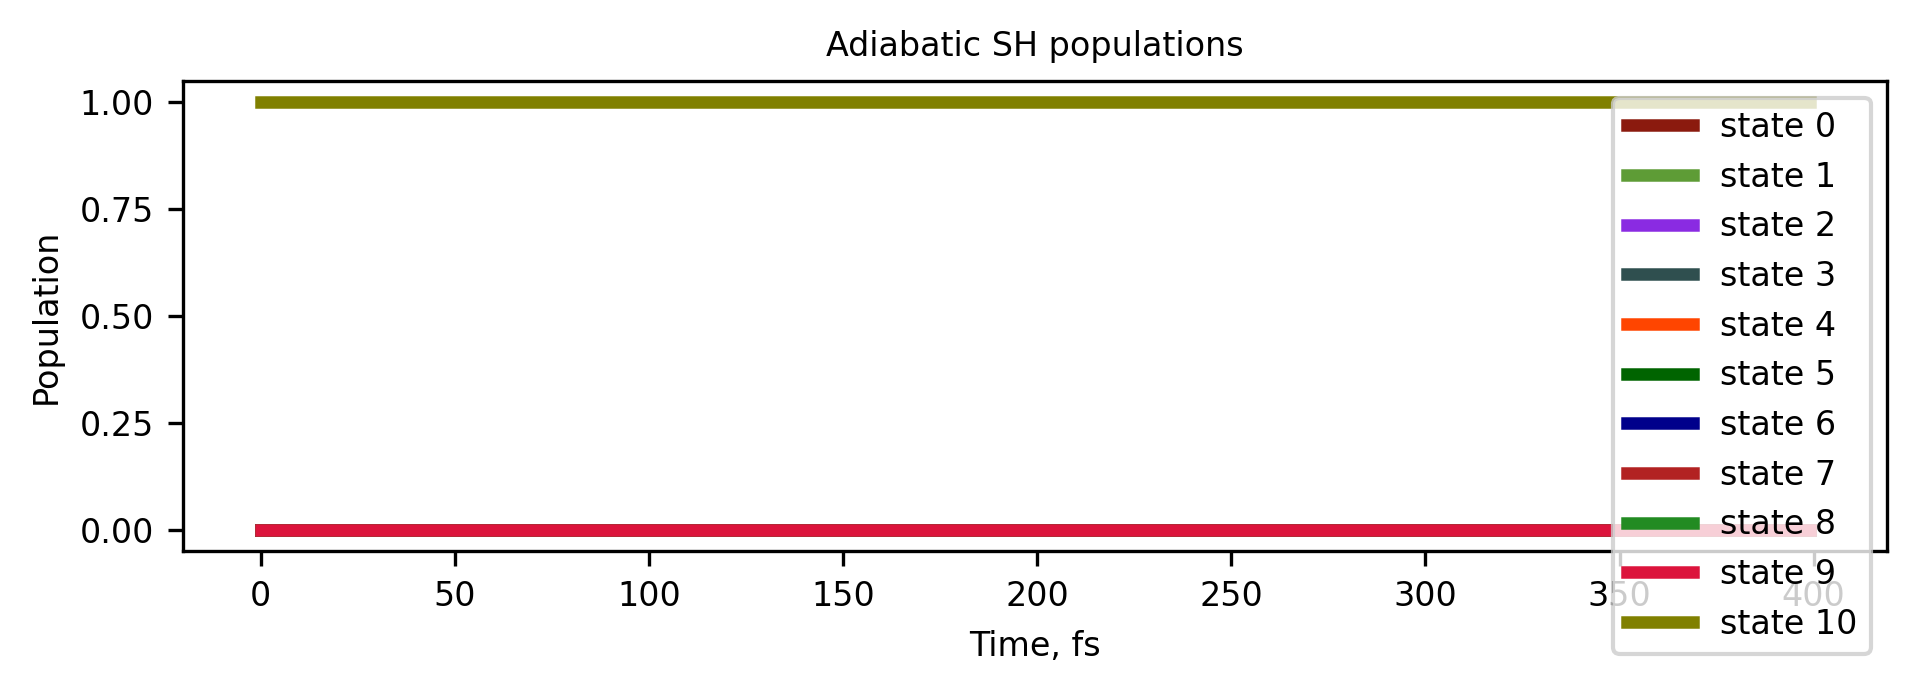

In [28]:
pref = "DISH_NBRA_icond_0"

nst = model_params["nstates"]
ntraj = dyn_general["ntraj"]

plot_params = { "prefix":pref, "filename":"mem_data.hdf", "output_level":2,
                "which_trajectories":list(range(ntraj)), "which_dofs":[0], "which_adi_states":list(range(nst)), 
                "which_dia_states":list(range(nst)), 
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":["se_pop_adi", "sh_pop_adi" ], 
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":1, "do_show":1
              }

for method in ['FSSH', 'mSDM', 'IDA', 'DISH']:
    print(F'Plotting results for method {method}')
    pref = F"{method}_NBRA_icond_0"
    plot_params.update({"prefix": pref})
    tsh_dynamics_plot.plot_dynamics(plot_params)